In [1]:
from functions import *
import cmapy

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Only GPU 1 is visible to this code

In [2]:
seis_path = '/data/anyu/thebetraintest/seistest.npy'

In [3]:
seis = np.load(seis_path)

In [4]:
IL, Z, XL = seis.shape
print(IL, Z, XL)

703 1537 3174


In [5]:
fault = np.load("/data/anyu/thebetraintest/faulttest.npy")
print(fault.shape)

(703, 1537, 3174)


Make input is IL, Z, XL order.

In [5]:
print(seis.shape)

(703, 1537, 3174)


In [6]:
im_height = Z
im_width = XL
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize

In [7]:
horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

34
3264
45 45
17
1632
47 48


In [8]:
horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)

In [9]:
halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)

0


In [10]:
print(len(seis))

703


In [11]:
t_start = time.time()
X_list = []
for i in range(100,105,5): #len(seis)
    img = seis[i]
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))

# X_norm = X

# if len(X_norm.shape) == 3:
#     X_norm = np.expand_dims(X_norm, axis=1)
# print(X_norm.shape) #float32

578
(96, 96)
read images in 0.033724069595336914 sec
(578, 96, 96)
read images in 0.048316001892089844 sec


In [12]:
X = X.astype(np.float32)
X = np.expand_dims(X,1)
print(X.shape)

(578, 1, 96, 96)


In [13]:
# idea from: https://www.kaggle.com/erikistre/pytorch-basic-u-net
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """

        self.images = preprocessed_images


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image


In [14]:

faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [15]:
modelNo = 0
currentpath = "/home/anyu/myproject/venv/an/all_model_new/sharefiles_origin/noaugmodelsseed"
mergemethod = "smooth" # smooth average crop
device = torch.device("cuda")
if modelNo == 0:
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    modelname = "unet_96_48_900200_seed"
    best_model_fpath = '{}/{}.model'.format(currentpath,modelname) #models/
    save_path = '{}/overlap_clean_predictions/{}_{}'.format(currentpath,modelname,mergemethod)
elif modelNo == 1:
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    modelname = "mobilenet_96_48_900200_seed"
    best_model_fpath = '{}/{}.model'.format(currentpath,modelname) #models/
    save_path = '{}/overlap_clean_predictions/{}_{}'.format(currentpath,modelname,mergemethod)
elif modelNo == 2:
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") 
    modelname = "hed_96_48_900200_seed3"
    best_model_fpath = '{}/{}.model'.format(currentpath,modelname) #models/
    save_path = '{}/overlap_clean_predictions/{}_{}'.format(currentpath,modelname,mergemethod)
elif modelNo == 3:
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    modelname = "rcf_96_48_900200_seed"
    best_model_fpath = '{}/{}.model'.format(currentpath,modelname) #models/
    save_path = '{}/overlap_clean_predictions/{}_{}'.format(currentpath,modelname,mergemethod)
else:
    print("please enter a valid model")
print(best_model_fpath)
print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
summary(model, (1, splitsize, splitsize))#,device='cpu')

use model Unet
/home/anyu/myproject/venv/an/all_model_new/sharefiles_origin/noaugmodelsseed/unet_96_48_900200_seed.model
/home/anyu/myproject/venv/an/all_model_new/sharefiles_origin/noaugmodelsseed/overlap_clean_predictions/unet_96_48_900200_seed_average
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         Dropout2d-4           [-1, 32, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           9,248
       BatchNorm2d-6           [-1, 32, 96, 96]              64
              ReLU-7           [-1, 32, 96, 96]               0
         Dropout2d-8           [-1, 32, 96, 96]               0
       double_conv-9           [-1, 32, 96, 96]               0
        MaxPool2d-10           [-1, 32, 

In [16]:
UPPER_BOUND = 800
LOWER_BOUND = 1300
print("UPPER_BOUND",UPPER_BOUND)
print("LOWER_BOUND",LOWER_BOUND)
    
def saveResults(save_path, test_loader):     
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    for images in test_loader:
        images = Variable(images.cuda())
        outputs = model(images)
        y_preds = outputs
        if modelNo == 2:
            y_preds = outputs[-2]
        elif modelNo == 3:
            y_preds = outputs[-1]
        test_predictions.extend(y_preds.detach().cpu())
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            if mergemethod == "smooth":
                WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
                tosave = np.moveaxis(tosave,-3,-1)
                tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
                tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
                recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)
                os.makedirs(save_path, exist_ok=True)
                np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred)[UPPER_BOUND:LOWER_BOUND,:])   
            elif mergemethod == "average":
                tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
                recover_Y_test_pred = recover_Image(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad, overlapsize)
                os.makedirs(save_path, exist_ok=True)
                np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred)[UPPER_BOUND:LOWER_BOUND,:])
            elif mergemethod == "crop":
                tosave= crop2(tosave,48,48)
                tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, 48,48,1))
                recover_Y_test_pred = recover_Image(tosave, (im_height,im_width,1), left_pad-halfoverlapsize,right_pad-halfoverlapsize,top_pad-halfoverlapsize,bottom_pad-halfoverlapsize,0)
                os.makedirs(save_path, exist_ok=True)
                np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred)[UPPER_BOUND:LOWER_BOUND,:])
            else:
                print("please enter an valida merge method")
                        

print("save")
t1 = time.time()
saveResults(save_path, test_loader)
t2 = time.time()
print('save in {} sec'.format(t2-t1))

UPPER_BOUND 800
LOWER_BOUND 1300
save
save in 0.5154955387115479 sec


In [17]:
a = np.load(os.path.join(save_path,"0.npy"))


In [18]:
heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(20,16))
plt.imshow(heatmap_img)
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()

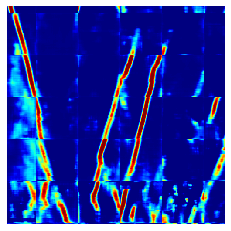

In [19]:
# heatmap_img = cv2.applyColorMap((a[:,2000:2500]*255).astype(np.uint8), cmapy.cmap('jet_r'))
# plt.figure(figsize=(4,4))
# plt.imshow(heatmap_img)
# # plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.savefig("nomerge.png",bbox_inches="tight")
# # plt.show()

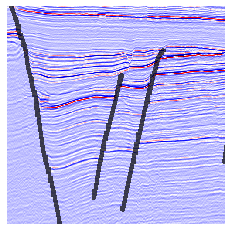

In [20]:
# heatmap_img = cv2.applyColorMap((a[:,2000:2500]*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(4,4))
# plt.imshow(seis[100,800:1300,2000:2500])
plt.imshow(seis[100,800:1300,2000:2500],'seismic')
plt.imshow(faultmask, 'gray', alpha=0.7)
# plt.imshow(fault[100,800:1300,2000:2500])
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.savefig("seismicfault.jpg",dpi=300, bbox_inches="tight")
# plt.show()